# Capstone project : Tomato price variation factors.

A warm season crop, sensitive to frost. It is usually cultivated in sub-tropical and mild cold climatic regions. It thrives well in temperature 10C to 30C with optimum range of temperature is 21-24C. The mean temperature below 16C and above 27C are not desirable. Thus temperature affects the germination, crop standing and ultimately affects yield, quality and price.


In heavy soils if drainage is not provided, higher moisture content and water stagnation causes ill effects on tomato that is fruit quality deteriorate due to spots on fruits, incidence of pest and diseases. The soil humidity is bad to the production. 

Full ripe tomatoes are stored at a temperature of 12,8C for up to several days. Temperatures cooler than this will cause chilling injury, producing poor colors and off flavors.

• Quality

Due to improper storage, there is a loss in fresh weight of about 10-15%. This causes them to appear shriveled and stale, thus considerably lowering their market value and consumer acceptability. Proper storage facilities are important in stabilizing the supplies by carrying over the produce from periods of high production to periods of low production.

• Price

In the absence of storage facilities, the producer would be forced to put his products on the market soon after harvest, immaterial of the demand. Thus resulting in a glut and market stagnation with consequent loss to the producer. This would benefit the consumer since the prices would drop. But, the farmer could price the very high when the demand is greater than the supply.

# Feature engineering

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import register_matplotlib_converters

In [2]:
# I load data: the data is a sample of weekly vegetables price
data_2017_2015 = pd.read_excel("data/tomato_price_2017_2015.xls")
data_2019_2018 = pd.read_excel("data/tomato_price_2019_2018.xls")
del data_2017_2015['Week ending']
del data_2019_2018['Week ending']

# I reemplace missing values with the column mean
data_2017_2015 = data_2017_2015.fillna(value=round(data_2017_2015.mean(), 2))
data_2019_2018 = data_2019_2018.fillna(value=round(data_2019_2018.mean(),2))

data_2017_2015.head(3)

,Unnamed: 0,2/1/15,9/1/15,16/1/15,23/1/15,30/1/15,6/2/15,13/2/15,20/2/15,27/2/15,...,27/10/17,3/11/17,10/11/17,17/11/17,24/11/17,1/12/17,8/12/17,15/12/17,22/12/17,29/12/17
0,Butterhead – Indoor Lettuce,0.33,0.33,0.34,0.33,0.33,0.33,0.33,0.34,0.33,...,0.32,0.33,0.34,0.34,0.33,0.33,0.33,0.33,0.33,0.33
1,Salad Onions,0.48,0.33,0.34,0.33,0.33,0.33,0.33,0.34,0.33,...,0.27,0.28,0.28,0.58,0.55,0.15,0.62,0.62,0.62,0.62
2,Round tomato,0.62,0.33,0.34,0.33,0.33,0.33,0.33,0.34,0.33,...,1.12,0.97,0.95,0.81,0.77,0.69,0.69,0.69,0.69,0.69


In [3]:
# I check dataframes size
data_2017_2015.shape[1] + data_2019_2018.shape[1]  


263

In [4]:
# Like date are the columns names, and I need do date like index of dataframe, 
#I applied Transpose and I build a DataFrame
all_data = []
for dataset in [data_2017_2015, data_2019_2018]:
    data_tmp = dataset.copy()
    data_tmp = data_tmp.set_index('Unnamed: 0')
    data_tmp= data_tmp.transpose()
    data_tmp.index = pd.DatetimeIndex(data=data_tmp.index, name='date', dayfirst=True)
    data_tmp = data_tmp.sort_index()
    all_data.append(data_tmp)
    
# make columns the same
all_data[0].columns = all_data[1].columns

#concat
full_data = pd.concat(all_data)
# rename index
full_data.index.rename('date')
full_data.index

DatetimeIndex(['2015-01-02', '2015-01-09', '2015-01-16', '2015-01-23',
               '2015-01-30', '2015-02-06', '2015-02-13', '2015-02-20',
               '2015-02-27', '2015-03-06',
               ...
               '2019-10-25', '2019-11-01', '2019-11-08', '2019-11-15',
               '2019-11-22', '2019-11-29', '2019-12-06', '2019-12-13',
               '2019-12-20', '2019-12-27'],
              dtype='datetime64[ns]', name='date', length=261, freq=None)

In [5]:
# I build dataframe only with tomato_price

data_tomato_price = pd.DataFrame(np.array(full_data['Round Tomato']), 
    columns=['tomato_price'], \
    index=full_data.index)
# I save data like csv to use with Prophet in another jupyter notebook
data_tomato_price.to_csv('data_tomato_price.csv')

data_tomato_price.head(3)

,tomato_price
date,
2015-01-02,0.62
2015-01-09,0.33
2015-01-16,0.34


In [6]:
# The same steps to lettuce price

data_lettuce_price = pd.DataFrame(np.array(full_data['Butterhead Indoor Lettuce']), 
    columns=['lettuce_price'], \
    index=full_data.index)

data_lettuce_price.tail(3)

,lettuce_price
date,
2019-12-13,0.43
2019-12-20,0.42
2019-12-27,0.42


In [7]:
# The same steps to onion price

data_onion_price= pd.DataFrame(np.array(full_data['salad onion']), 
    columns=['onion_price'], \
    index=full_data.index)

data_onion_price.head(3) 

,onion_price
date,
2015-01-02,0.48
2015-01-09,0.33
2015-01-16,0.34


In [8]:
# I Generate descriptive statistics to see data
data_tomato_price.describe(include='all')

,tomato_price
count,260.000000
mean,0.860538
std,0.399055
min,0.230000
25%,0.555000
50%,0.885000
75%,1.060000
max,2.570000


In [9]:
# I get the number of missing values
sum(data_tomato_price.apply(pd.isna).sum())

1

In [10]:
# I get monthly data to work with monthly whether, I need to change type data to float to use resample
data_tomato_price = data_tomato_price.astype('float')
monthly_tomato_price = data_tomato_price.resample('M').mean()
monthly_tomato_price.head(3)

,tomato_price
date,
2015-01-31,0.3900
2015-02-28,0.3325
2015-03-31,1.1600


In [11]:
monthly_tomato_price.shape

(60, 1)

#  Exploratory data

/Users/pola/miniconda3/envs/ads08/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


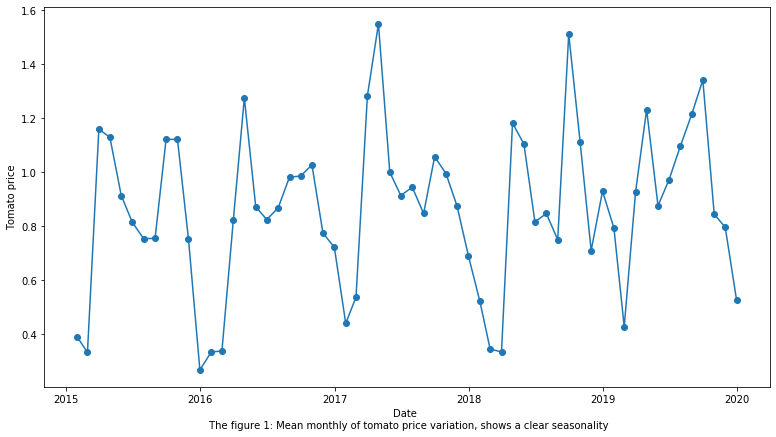

In [12]:
#I chart to explore montly tomato price

plt.figure(figsize=(13, 7))
plt.plot(monthly_tomato_price.index, monthly_tomato_price["tomato_price"], "-o")
plt.xlabel('Date \n The figure 1: Mean monthly of tomato price variation, shows a clear seasonality' )
plt.ylabel('Tomato price')

plt.show()

We can see a clear seasonality: approximately at the beginning and end of the year, the price is higher,
and a low price in the middle of the year

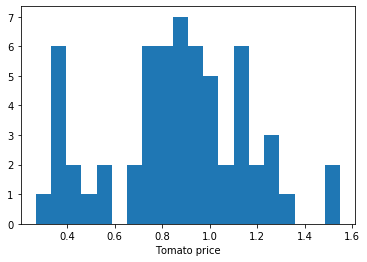

In [13]:
# Histogram to explore montly tomato price
plt.hist((monthly_tomato_price['tomato_price']), bins=20)
plt.xlabel('Tomato price')
plt.show()


We can see the most frequent value, at the peak it is approximately 0.9, and 1.5 could be atypical value

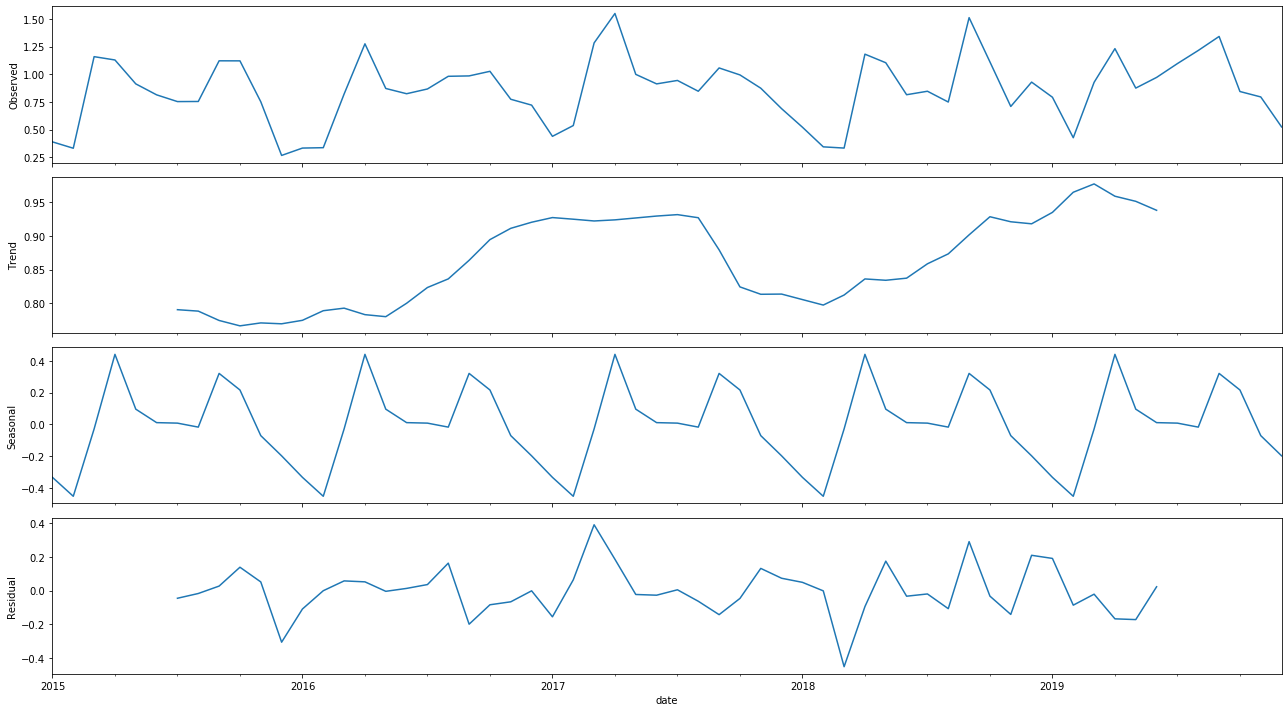

In [14]:
# In the seasonal chart its can see: in March, the highest price
# in January lowest price
from pylab import rcParams
import statsmodels.api as sm
rcParams['figure.figsize'] = 18, 10

decomposition = sm.tsa.seasonal_decompose(monthly_tomato_price, model='additive')
fig = decomposition.plot()
plt.show()

In [15]:
# function to scale prices
def chart_scale(column):
    column_scaled = column / 10
    return round(column_scaled, 2)


In [16]:
# I read and parse weather data of BOGNOR REGIS, West Sussex where are tomatoes production
weather = pd.read_csv("data/temperatures_UK.csv", sep=';', \
    parse_dates=['day'], \
    index_col='day')
weather.sort_index(inplace=True)
weather.tail(3)

,temperature_max,temperature_min,humidity,precip_intensity,precip_intensity_max,pressure,visibility,wind_speed
day,,,,,,,,
2019-12-23 00:00:00+00:00,10.75,7.17,0.87,0.0108,0.1126,1008.5,10.0,16.79
2019-12-25 00:00:00+00:00,8.55,4.30,0.86,0.0014,0.0098,1024.2,10.0,7.55
2019-12-27 00:00:00+00:00,9.56,4.64,0.93,0.0069,0.1352,1029.3,10.0,6.39


In [17]:
#I check the missing values
weather.apply(pd.isna).sum()

temperature_max          0
temperature_min          0
humidity                 0
precip_intensity        22
precip_intensity_max    22
pressure                22
visibility               0
wind_speed               0
dtype: int64

In [18]:
# I reemplace missing value for the mean
weather = weather.fillna(value=weather.mean())
weather.apply(pd.isna).sum()

temperature_max         0
temperature_min         0
humidity                0
precip_intensity        0
precip_intensity_max    0
pressure                0
visibility              0
wind_speed              0
dtype: int64

In [19]:
# I build monthly weather DataFrame
monthly_whether = weather.resample('M').mean()
monthly_whether.shape

(60, 8)

In [20]:
# I scale whether
monthly_whether['temperature_max'] = monthly_whether['temperature_max'].apply(chart_scale)
monthly_whether['temperature_min'] = monthly_whether['temperature_min'].apply(chart_scale)
monthly_whether['precip_intensity'] = monthly_whether['precip_intensity'].apply(chart_scale)
monthly_whether['precip_intensity_max'] = monthly_whether['precip_intensity_max'].apply(chart_scale)
monthly_whether['pressure'] = monthly_whether['pressure'].apply(chart_scale)
monthly_whether['visibility'] = monthly_whether['visibility'].apply(chart_scale)
monthly_whether['wind_speed'] = monthly_whether['wind_speed'].apply(chart_scale)
monthly_whether.head(2)

,temperature_max,temperature_min,humidity,precip_intensity,precip_intensity_max,pressure,visibility,wind_speed
day,,,,,,,,
2015-01-31 00:00:00+00:00,0.86,0.22,0.866429,2.21,2.45,101.42,450.37,0.55
2015-02-28 00:00:00+00:00,0.80,0.19,0.842143,0.01,0.02,101.66,559.40,0.42


In [21]:
# I build a DataFrame with all data to see the charts
whether_tomato_price = monthly_whether.copy()
tomato_price = list(monthly_tomato_price['tomato_price'])
whether_tomato_price['tomato_price'] = tomato_price
whether_tomato_price.shape

(60, 9)

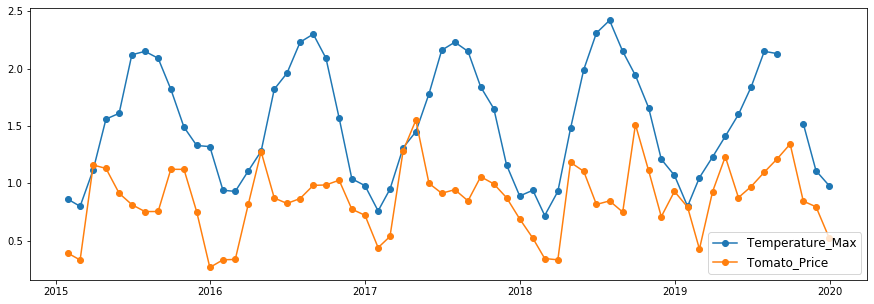

In [22]:
#I chart to compare Tomato_Price and  Temperature_Max

plt.figure(figsize=(15, 5))
plt.plot(whether_tomato_price.temperature_max, 
         '-o', label='Temperature_Max')
plt.plot(whether_tomato_price.tomato_price, 
         '-o', label='Tomato_Price')
plt.legend(fontsize=12)

Could be a relation when the temperature_Max drops the price of the tomato is lower

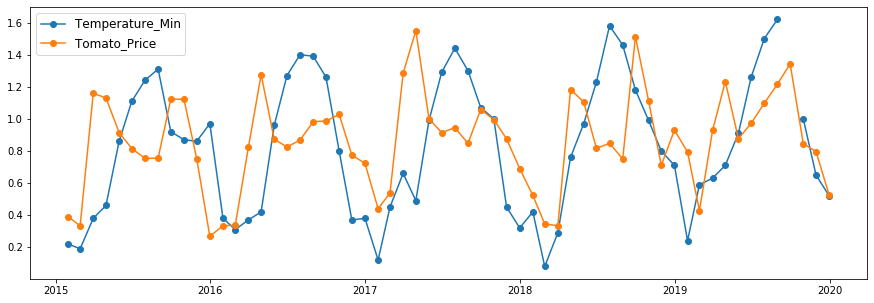

In [23]:
#I chart to compare Tomato_Price and  Temperature_Min
plt.figure(figsize=(15, 5))

plt.plot(whether_tomato_price.temperature_min, 
         '-o', label='Temperature_Min')
plt.plot(whether_tomato_price.tomato_price, 
         '-o', label='Tomato_Price')
plt.legend(fontsize=12)

In general, the drop of minimum temperature coincides with the lowest tomato prices, could be related.

In [24]:
# # I read and parse oil prices(GBP) in all_data DataFrame
oil_prices = pd.read_csv("data/oil_prices.csv", \
    parse_dates=['Date'], \
    index_col='Date')
oil_prices.sort_index(inplace=True)
oil_prices.head(3)

,date_human,Currency,oil_price
Date,,,
2015-01-02,Friday 2 January 2015,OIL/GBP,34.3404
2015-01-03,Saturday 3 January 2015,OIL/GBP,34.3404
2015-01-04,Sunday 4 January 2015,OIL/GBP,34.1714


In [25]:
# I delete the feature of oil_prices that I will not use
del oil_prices['date_human']
del oil_prices['Currency']
oil_prices.head(2)

,oil_price
Date,
2015-01-02,34.3404
2015-01-03,34.3404


In [26]:

monthly_oil_prices = oil_prices.resample('M').mean()
monthly_oil_prices.tail(3)


,oil_price
Date,
2019-10-31,42.747126
2019-11-30,44.349840
2019-12-31,45.620271


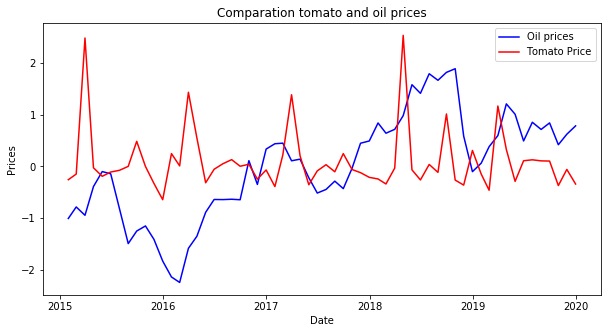

In [27]:
# I scale oil_prices and tomato price

mean_oil_prices = monthly_oil_prices.oil_price.mean()
std_oil_prices = monthly_oil_prices.oil_price.std()
oil_prices_scaled = monthly_oil_prices['oil_price'].apply(lambda x: (x-mean_oil_prices)/std_oil_prices)
i=1
tomato_price_scaled = np.array([])
for i in range(monthly_tomato_price.shape[0]):
    value = (monthly_tomato_price.iloc[i, 0] - monthly_tomato_price.iloc[i-1, 0])/monthly_tomato_price.iloc[i-1, 0] 
    tomato_price_scaled = np.append(tomato_price_scaled, value)
tomato_price_scaled = pd.DataFrame(tomato_price_scaled)

# I chart tomato and oil price
plt.figure(figsize=(10, 5))
plt.plot(monthly_oil_prices.index, oil_prices_scaled , 'b-', label = 'Oil prices')
plt.plot(monthly_tomato_price.index, tomato_price_scaled, 'r-', label = 'Tomato Price')
plt.xlabel('Date'); plt.ylabel('Prices'); plt.title('Comparation tomato and oil prices')
plt.legend();


In general, the peak in tomato prices coincides with the rise in oil prices

In [28]:
all_features = monthly_whether.copy()
all_features['oil_price'] = list(monthly_oil_prices['oil_price'])
#I add lettuce, onion and tomato price features in all_features dataset before to save
data_lettuce_price = data_lettuce_price.astype('float')
data_onion_price = data_onion_price.astype('float')
monthly_lettuce_price = data_lettuce_price.resample('M').mean()
monthly_onion_price = data_onion_price.resample('M').mean()
all_features['lettuce_price'] = list(monthly_lettuce_price['lettuce_price'])
all_features['onion_price'] = list(monthly_onion_price['onion_price'])
all_features['tomato_price'] = tomato_price
# I save all_data DataFrame to use them in Random Forest model
all_features.to_csv('all_data.csv')
all_features.tail(3)

,temperature_max,temperature_min,humidity,precip_intensity,precip_intensity_max,pressure,visibility,wind_speed,oil_price,lettuce_price,onion_price,tomato_price
day,,,,,,,,,,,,
2019-10-31 00:00:00+00:00,1.52,1.00,0.835333,3.06,22.94,101.17,377.53,1.51,42.747126,0.400,0.270,0.845
2019-11-30 00:00:00+00:00,1.11,0.65,0.888667,2.65,12.03,100.11,485.80,1.35,44.349840,0.406,0.622,0.796
2019-12-31 00:00:00+00:00,0.98,0.52,0.862857,0.01,0.14,100.86,459.94,1.57,45.620271,0.425,0.525,0.525


/Users/pola/miniconda3/envs/ads08/lib/python3.7/site-packages/pandas/core/arrays/datetimes.py:1269: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  UserWarning,


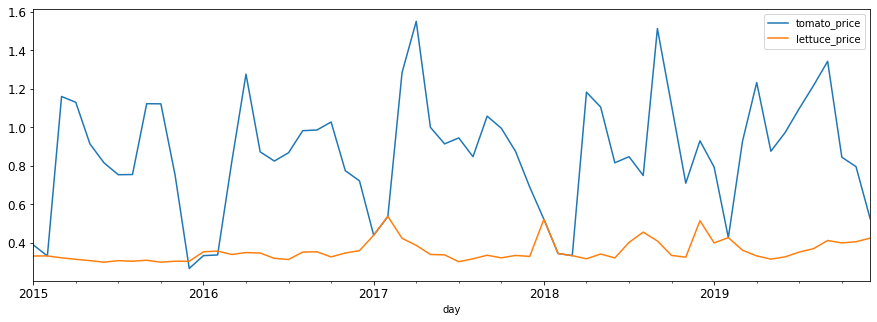

In [29]:
# chart to compare tomato and lettuce
all_features.plot(y=['tomato_price', 'lettuce_price'], figsize=(15, 5), fontsize=12)

The peak of tomato prices could be related with drop lettuce price.

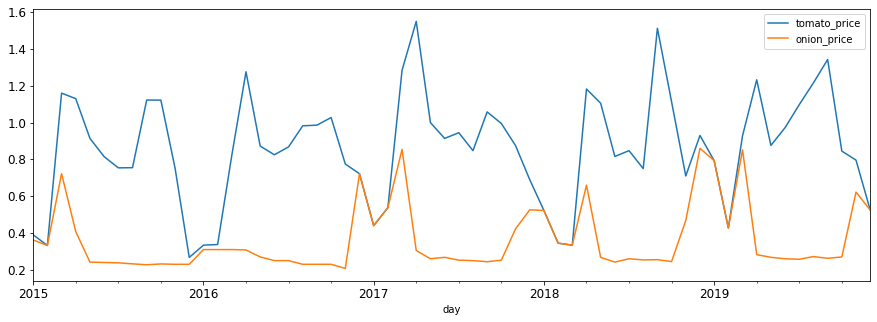

In [30]:
# chart to compare tomato and onion price
all_features.plot(y=['tomato_price', 'onion_price'], figsize=(15, 5), fontsize=12)

The plots show that the two time series have similar patterns in terms of seasonality but different trends
The drop of onion price could be related with the peak of tomato prices


In [31]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
#mean
def rolling_avg_plot(window_size):
    plt.plot(all_features.tomato_price, 
             '-o', label='Tomato_Price')
    rolling = all_features.tomato_price.rolling(window=window_size).mean()
    plt.plot(rolling, label='trend')
    plt.legend();
    plt.show()

interact(rolling_avg_plot, window_size=(0, 10));

interactive(children=(IntSlider(value=5, description='window_size', max=10), Output()), _dom_classes=('widget-…

The rolling mean curve seems to capture the trend nicely 

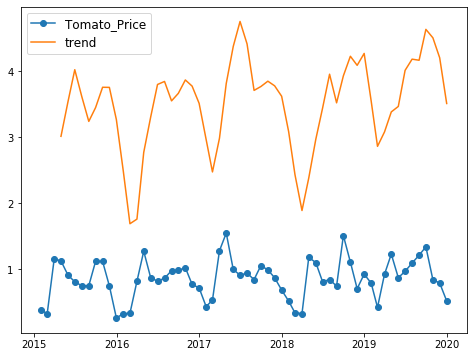

In [32]:
#sum
plt.figure(figsize=(8, 6))
plt.plot(all_features.tomato_price,
         '-o', label='Tomato_Price')
rolling_mean = all_features.tomato_price.rolling(window=4).sum()
plt.plot(rolling_mean, label='trend')
plt.legend(fontsize=12);

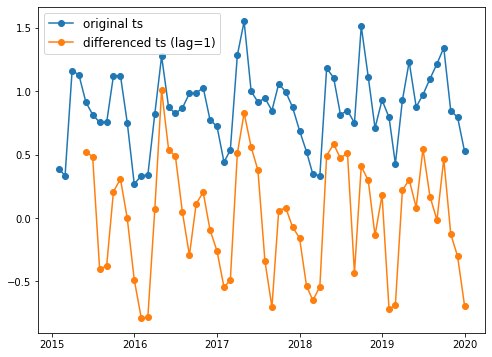

In [33]:
#diff
plt.figure(figsize=(8, 6))
plt.plot(all_features.tomato_price, '-o', 
         label="original ts")
plt.plot(all_features.tomato_price.diff(4), '-o', 
         label="differenced ts (lag=1)")
plt.legend(fontsize=12)

# Autocorrelation

/Users/pola/miniconda3/envs/ads08/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  """


Text(0, 0.5, 'Autocorrelation')

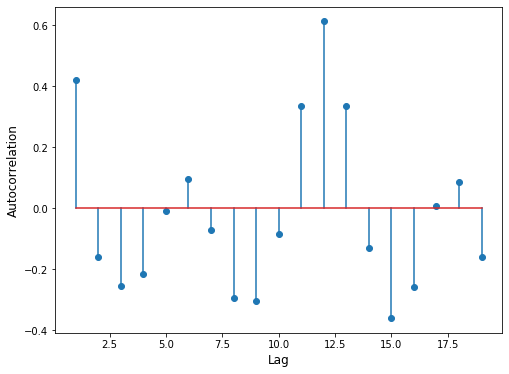

In [34]:
lags = range(1, 20)
autocorrs = [all_features.tomato_price.autocorr(lag=lag) 
                   for lag in lags]
plt.figure(figsize=(8, 6))
plt.stem(lags, autocorrs)
plt.xlabel("Lag", fontsize=12)
plt.ylabel("Autocorrelation", fontsize=12)

The autocorrelation plot indicates that the tomato price are not highly correlated. Could have a correlation between 0 and 12
